In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure, data
from skimage.io import imread, imsave
import pipeline
import Unet

In [46]:
def elastic_transform(image, alpha, sigma, rand_arr1, rand_arr2):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    shape = image.shape

#     dx = 0
#     dy = 0
    dx = gaussian_filter((rand_arr1 * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((rand_arr2 * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [178]:
def restore_valid_labels(cross_section, true_labels):
    scaled_labels = true_labels * 10
    restored_cross_section = np.empty_like(cross_section)
    for i in range(cross_section.shape[0]):
        for j in range(cross_section.shape[1]):
            scaled_val = cross_section[i][j]
            restored_cross_section[i][j] = get_closest_value(scaled_val, scaled_labels)
            restored_cross_section[i][j] = restored_cross_section[i][j] // 10
    return restored_cross_section

In [170]:
def get_closest_value(target, values):
    # type(values) is numpy.ndarray
    idx = (np.abs(values - target)).argmin()
    return values[idx]

In [190]:
all_orig_labels = [0, 7, 8, 9, 45, 51, 52, 53, 68]
forward = {0: 0, 7: 100, 8: 200, 9: 300, 45: 400, 51: 500, 52: 600, 53: 700, 68: 800}
inverse = {0: 0, 100: 7, 200: 8, 300: 9, 400: 45, 500: 51, 600: 52, 700: 53, 800: 68}

def spread_compress_labels(cross_section, mode):
    if mode == 'spread':
        return np.asarray([forward[i] for i in cross_section.flatten()]).reshape(cross_section.shape)
    elif mode == 'compress':
        return np.asarray([inverse[i] for i in cross_section.flatten()]).reshape(cross_section.shape)
    else:
        return None

In [173]:
nii_data_dir = "/Users/nozik/Documents/HARTresearch/allrawfillednifti"
nii_vol_name = "trial8_30_fs_proc_filled_volume.nii"
nii_seg_name = "trial8_30_fs_proc_filled_seg.nii"

In [174]:
nii_vol = nib.load(os.path.join(nii_data_dir, nii_vol_name))
nii_seg = nib.load(os.path.join(nii_data_dir, nii_seg_name))

In [175]:
nii_vol_arr = nii_vol.get_fdata()
nii_seg_arr = nii_seg.get_fdata()

In [176]:
print(nii_vol_arr.shape, nii_seg_arr.shape)

(996, 512, 512) (996, 512, 512)


In [177]:
print(np.unique(nii_seg_arr).shape)

(9,)


In [179]:
exvol = nii_vol_arr[500]
exseg = nii_seg_arr[500]

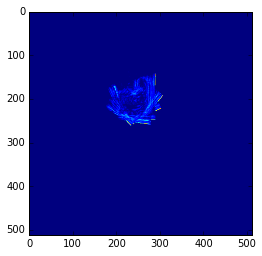

In [180]:
plt.imshow(exvol)

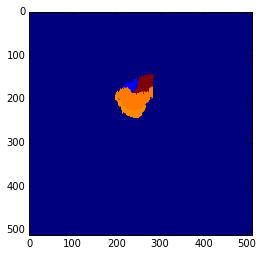

In [181]:
plt.imshow(exseg)

In [182]:
seed = np.random.randint(0, 2 ** 32 - 1)
randomizer = np.random.RandomState(seed)
shape = exvol.shape
rand_arr1 = randomizer.rand(*shape)
rand_arr2 = randomizer.rand(*shape)
deformedvol = elastic_transform(exvol, 34, 10, rand_arr1, rand_arr2)

False
False


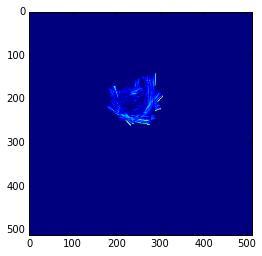

In [183]:
plt.imshow(deformedvol)
print(np.unique(exvol).shape == np.unique(deformedvol).shape)
print(np.all(exvol == deformedvol))

In [184]:
deformedseg = elastic_transform(exseg * 10, 34, 10, rand_arr1, rand_arr2)

False
False


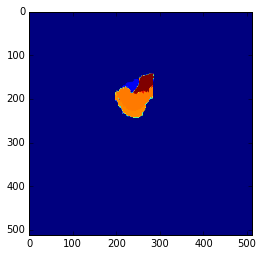

In [185]:
plt.imshow(deformedseg)
print(np.unique(exseg).shape == np.unique(deformedseg).shape)
print(np.all(exseg == deformedseg))

In [186]:
true_labels = np.unique(exseg)
print(true_labels)
restored_deformedseg = restore_valid_labels(deformedseg, true_labels)

[ 0.  7. 52. 53. 68.]


True
(5,) (5,)
False
[-0.  7. 52. 53. 68.]


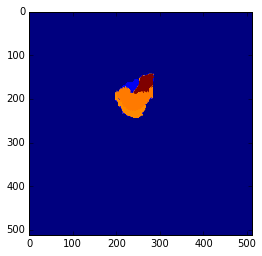

In [187]:
plt.imshow(restored_deformedseg)
print(np.unique(exseg).shape == np.unique(restored_deformedseg).shape)
print(np.unique(exseg).shape, np.unique(restored_deformedseg).shape)
print(np.all(exseg == restored_deformedseg))
print(np.unique(restored_deformedseg))

In [188]:
def elastic_transform_nifti(nifti_vol_arr, nifti_seg_arr, alpha, sigma):
    transformed_vol_arr = np.empty(nifti_vol_arr.shape)
    transformed_seg_arr = np.empty(nifti_seg_arr.shape)
    seed = np.random.randint(0, 2 ** 32 - 1)
    randomizer = np.random.RandomState(seed)
    for i in range(nifti_vol_arr.shape[0]):
        print(i, end='; ')
        rand_arr1 = randomizer.rand(*nifti_vol_arr[i].shape)
        rand_arr2 = randomizer.rand(*nifti_vol_arr[i].shape)
        print("About to transform vol slice;", end=' ')
        transformed_vol_slice = elastic_transform(nifti_vol_arr[i], alpha, sigma, rand_arr1, rand_arr2)
        print("About to transform seg slice;", end=' ')
        true_orig_labels = np.unique(nifti_seg_arr[i])
        transformed_seg_slice = nifti_seg_arr[i] * 10
        transformed_seg_slice = elastic_transform(transformed_seg_slice, alpha, sigma, rand_arr1, rand_arr2)
        transformed_seg_slice = restore_valid_labels(transformed_seg_slice, true_orig_labels)
        print("Done with transformations;", end=' ')
        transformed_vol_arr[i] = transformed_vol_slice
        transformed_seg_arr[i] = transformed_seg_slice
        print(' ')
    return transformed_vol_arr, transformed_seg_arr

transformed_vol_arr, transformed_seg_arr = elastic_transform_nifti(nii_vol_arr, nii_seg_arr, 34, 10)

0; About to transform vol slice; About to transform seg slice; Done with transformations;  
1; About to transform vol slice; About to transform seg slice; Done with transformations;  
2; About to transform vol slice; About to transform seg slice; Done with transformations;  
3; About to transform vol slice; About to transform seg slice; Done with transformations;  
4; About to transform vol slice; About to transform seg slice; Done with transformations;  
5; About to transform vol slice; About to transform seg slice; Done with transformations;  
6; About to transform vol slice; About to transform seg slice; Done with transformations;  
7; About to transform vol slice; About to transform seg slice; Done with transformations;  
8; About to transform vol slice; About to transform seg slice; Done with transformations;  
9; About to transform vol slice; About to transform seg slice; Done with transformations;  
10; About to transform vol slice; About to transform seg slice; Done with transf

88; About to transform vol slice; About to transform seg slice; Done with transformations;  
89; About to transform vol slice; About to transform seg slice; Done with transformations;  
90; About to transform vol slice; About to transform seg slice; Done with transformations;  
91; About to transform vol slice; About to transform seg slice; Done with transformations;  
92; About to transform vol slice; About to transform seg slice; Done with transformations;  
93; About to transform vol slice; About to transform seg slice; Done with transformations;  
94; About to transform vol slice; About to transform seg slice; Done with transformations;  
95; About to transform vol slice; About to transform seg slice; Done with transformations;  
96; About to transform vol slice; About to transform seg slice; Done with transformations;  
97; About to transform vol slice; About to transform seg slice; Done with transformations;  
98; About to transform vol slice; About to transform seg slice; Done w

175; About to transform vol slice; About to transform seg slice; Done with transformations;  
176; About to transform vol slice; About to transform seg slice; Done with transformations;  
177; About to transform vol slice; About to transform seg slice; Done with transformations;  
178; About to transform vol slice; About to transform seg slice; Done with transformations;  
179; About to transform vol slice; About to transform seg slice; Done with transformations;  
180; About to transform vol slice; About to transform seg slice; Done with transformations;  
181; About to transform vol slice; About to transform seg slice; Done with transformations;  
182; About to transform vol slice; About to transform seg slice; Done with transformations;  
183; About to transform vol slice; About to transform seg slice; Done with transformations;  
184; About to transform vol slice; About to transform seg slice; Done with transformations;  
185; About to transform vol slice; About to transform seg sl

262; About to transform vol slice; About to transform seg slice; Done with transformations;  
263; About to transform vol slice; About to transform seg slice; Done with transformations;  
264; About to transform vol slice; About to transform seg slice; Done with transformations;  
265; About to transform vol slice; About to transform seg slice; Done with transformations;  
266; About to transform vol slice; About to transform seg slice; Done with transformations;  
267; About to transform vol slice; About to transform seg slice; Done with transformations;  
268; About to transform vol slice; About to transform seg slice; Done with transformations;  
269; About to transform vol slice; About to transform seg slice; Done with transformations;  
270; About to transform vol slice; About to transform seg slice; Done with transformations;  
271; About to transform vol slice; About to transform seg slice; Done with transformations;  
272; About to transform vol slice; About to transform seg sl

349; About to transform vol slice; About to transform seg slice; Done with transformations;  
350; About to transform vol slice; About to transform seg slice; Done with transformations;  
351; About to transform vol slice; About to transform seg slice; Done with transformations;  
352; About to transform vol slice; About to transform seg slice; Done with transformations;  
353; About to transform vol slice; About to transform seg slice; Done with transformations;  
354; About to transform vol slice; About to transform seg slice; Done with transformations;  
355; About to transform vol slice; About to transform seg slice; Done with transformations;  
356; About to transform vol slice; About to transform seg slice; Done with transformations;  
357; About to transform vol slice; About to transform seg slice; Done with transformations;  
358; About to transform vol slice; About to transform seg slice; Done with transformations;  
359; About to transform vol slice; About to transform seg sl

436; About to transform vol slice; About to transform seg slice; Done with transformations;  
437; About to transform vol slice; About to transform seg slice; Done with transformations;  
438; About to transform vol slice; About to transform seg slice; Done with transformations;  
439; About to transform vol slice; About to transform seg slice; Done with transformations;  
440; About to transform vol slice; About to transform seg slice; Done with transformations;  
441; About to transform vol slice; About to transform seg slice; Done with transformations;  
442; About to transform vol slice; About to transform seg slice; Done with transformations;  
443; About to transform vol slice; About to transform seg slice; Done with transformations;  
444; About to transform vol slice; About to transform seg slice; Done with transformations;  
445; About to transform vol slice; About to transform seg slice; Done with transformations;  
446; About to transform vol slice; About to transform seg sl

523; About to transform vol slice; About to transform seg slice; Done with transformations;  
524; About to transform vol slice; About to transform seg slice; Done with transformations;  
525; About to transform vol slice; About to transform seg slice; Done with transformations;  
526; About to transform vol slice; About to transform seg slice; Done with transformations;  
527; About to transform vol slice; About to transform seg slice; Done with transformations;  
528; About to transform vol slice; About to transform seg slice; Done with transformations;  
529; About to transform vol slice; About to transform seg slice; Done with transformations;  
530; About to transform vol slice; About to transform seg slice; Done with transformations;  
531; About to transform vol slice; About to transform seg slice; Done with transformations;  
532; About to transform vol slice; About to transform seg slice; Done with transformations;  
533; About to transform vol slice; About to transform seg sl

610; About to transform vol slice; About to transform seg slice; Done with transformations;  
611; About to transform vol slice; About to transform seg slice; Done with transformations;  
612; About to transform vol slice; About to transform seg slice; Done with transformations;  
613; About to transform vol slice; About to transform seg slice; Done with transformations;  
614; About to transform vol slice; About to transform seg slice; Done with transformations;  
615; About to transform vol slice; About to transform seg slice; Done with transformations;  
616; About to transform vol slice; About to transform seg slice; Done with transformations;  
617; About to transform vol slice; About to transform seg slice; Done with transformations;  
618; About to transform vol slice; About to transform seg slice; Done with transformations;  
619; About to transform vol slice; About to transform seg slice; Done with transformations;  
620; About to transform vol slice; About to transform seg sl

697; About to transform vol slice; About to transform seg slice; Done with transformations;  
698; About to transform vol slice; About to transform seg slice; Done with transformations;  
699; About to transform vol slice; About to transform seg slice; Done with transformations;  
700; About to transform vol slice; About to transform seg slice; Done with transformations;  
701; About to transform vol slice; About to transform seg slice; Done with transformations;  
702; About to transform vol slice; About to transform seg slice; Done with transformations;  
703; About to transform vol slice; About to transform seg slice; Done with transformations;  
704; About to transform vol slice; About to transform seg slice; Done with transformations;  
705; About to transform vol slice; About to transform seg slice; Done with transformations;  
706; About to transform vol slice; About to transform seg slice; Done with transformations;  
707; About to transform vol slice; About to transform seg sl

784; About to transform vol slice; About to transform seg slice; Done with transformations;  
785; About to transform vol slice; About to transform seg slice; Done with transformations;  
786; About to transform vol slice; About to transform seg slice; Done with transformations;  
787; About to transform vol slice; About to transform seg slice; Done with transformations;  
788; About to transform vol slice; About to transform seg slice; Done with transformations;  
789; About to transform vol slice; About to transform seg slice; Done with transformations;  
790; About to transform vol slice; About to transform seg slice; Done with transformations;  
791; About to transform vol slice; About to transform seg slice; Done with transformations;  
792; About to transform vol slice; About to transform seg slice; Done with transformations;  
793; About to transform vol slice; About to transform seg slice; Done with transformations;  
794; About to transform vol slice; About to transform seg sl

871; About to transform vol slice; About to transform seg slice; Done with transformations;  
872; About to transform vol slice; About to transform seg slice; Done with transformations;  
873; About to transform vol slice; About to transform seg slice; Done with transformations;  
874; About to transform vol slice; About to transform seg slice; Done with transformations;  
875; About to transform vol slice; About to transform seg slice; Done with transformations;  
876; About to transform vol slice; About to transform seg slice; Done with transformations;  
877; About to transform vol slice; About to transform seg slice; Done with transformations;  
878; About to transform vol slice; About to transform seg slice; Done with transformations;  
879; About to transform vol slice; About to transform seg slice; Done with transformations;  
880; About to transform vol slice; About to transform seg slice; Done with transformations;  
881; About to transform vol slice; About to transform seg sl

958; About to transform vol slice; About to transform seg slice; Done with transformations;  
959; About to transform vol slice; About to transform seg slice; Done with transformations;  
960; About to transform vol slice; About to transform seg slice; Done with transformations;  
961; About to transform vol slice; About to transform seg slice; Done with transformations;  
962; About to transform vol slice; About to transform seg slice; Done with transformations;  
963; About to transform vol slice; About to transform seg slice; Done with transformations;  
964; About to transform vol slice; About to transform seg slice; Done with transformations;  
965; About to transform vol slice; About to transform seg slice; Done with transformations;  
966; About to transform vol slice; About to transform seg slice; Done with transformations;  
967; About to transform vol slice; About to transform seg slice; Done with transformations;  
968; About to transform vol slice; About to transform seg sl

In [192]:
nii_save_dir = "/Users/nozik/Documents/HARTresearch/augmented_data/elastic_transformed_nii"

In [193]:
pipeline.save_arr_as_nifti(transformed_vol_arr, nii_vol_name, "trial8_30_fs_vol_elast_3.nii", nii_data_dir, nii_save_dir)
pipeline.save_arr_as_nifti(transformed_seg_arr, nii_seg_name, "trial8_30_fs_seg_elast_3.nii", nii_data_dir, nii_save_dir)

In [111]:
np.unique(transformed_seg_arr).shape

(9,)

In [74]:
np.unique(nii_seg_arr).shape

(9,)